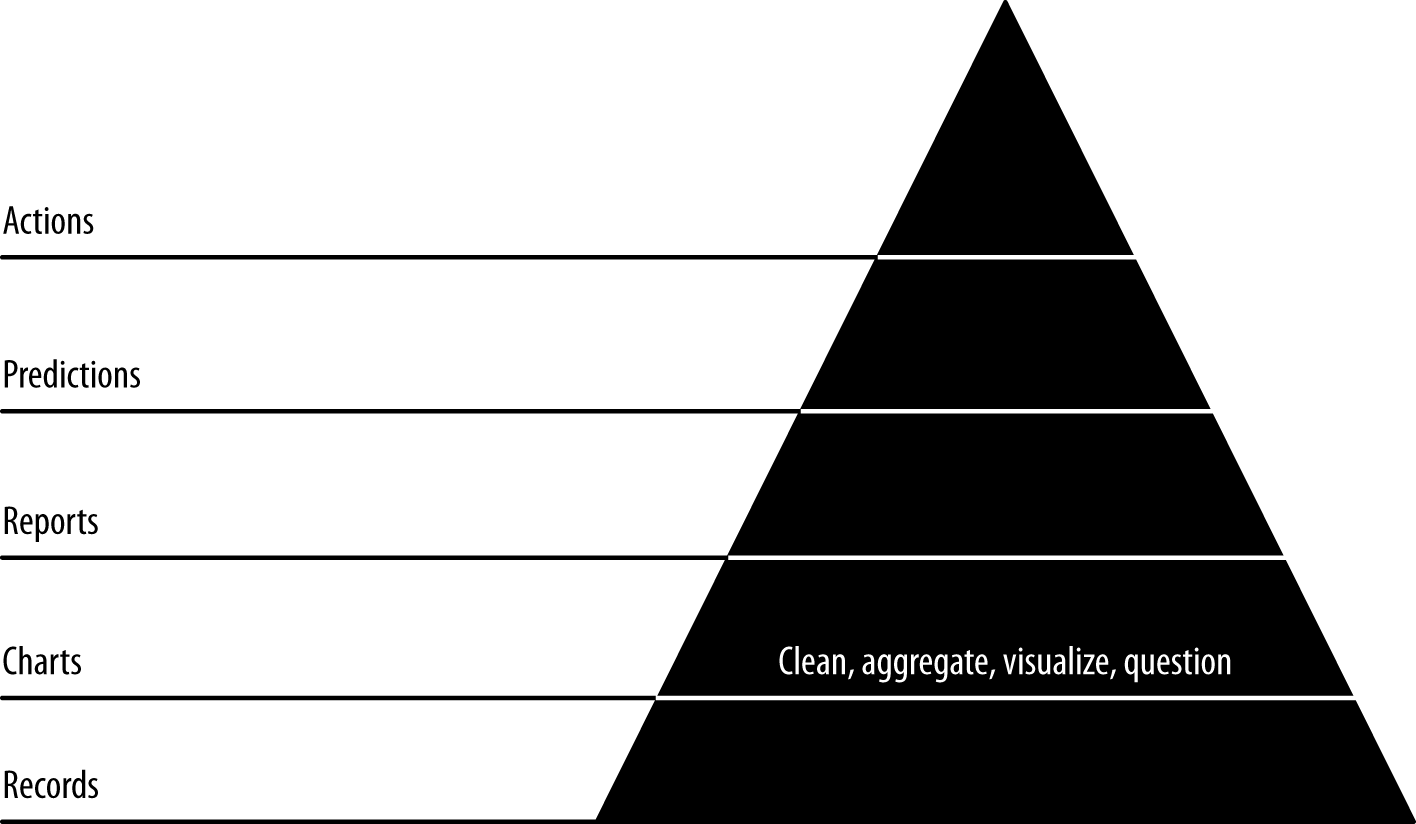

# Visualizing Data with Charts and Tables

Charts are our first view into our data in aggregate, mapping the properties of many records into visual representations that help us understand and navigate them. Our goals in this step are to publish charts to generate interest in our data and get users interacting with it, to build reusable tools that will help us explore our data interactively in reports in the next step, and to begin extracting structure and entities so that we can create new features and insights with this structure.

## Chart Quality: Iteration Is Essential

A good chart is one that tells a story, that yields insight, and that users find interesting enough to share and respond to. In practice, most charts fail to achieve this, and have little value. Rare is the chart that tells a story. This is because most people make a chart and move on… when in reality, you have to iteratively create and improve charts to achieve useful visualizations. Expect to throw many charts away before you find a few good ones—don’t try to specify them up front or you will be disappointed. Instead, try to use your intuition and curiosity to add charts organically, as you engage in ad hoc, interactive exploratory data analysis.

You can create charts in an ad hoc way at first, but as you progress, your workflow should become increasingly automated and reproducible. In Agile Data Science, we take a web-first approach to creating visualizations. While it is easier to create charts as images using matplotlib or R than it is to create web charts, this is changing fast. With modern JavaScript chart libraries, there isn’t much overhead to creating a web-based chart, so that is what we do from the beginning.

Well-formed URLs with slugs or query parameters can be made to generalize, so one chart works for different slices of data according to different parameters and options. Once we master charts, in the next chapter, we will improve and extend our successful charts into full-blown interactive reports.

## Scaling a Database in the Publish/Decorate Model

A concept related to database normalization that we must understand is how we compute, publish, and consume data for charts and other services, and where we put the data processing. The more processing you do in batch and the less processing you do at the publishing/database layer, the less you have to spend time operating a database. There are several patterns of data access that come with their own methods of data processing and database operations. We will briefly discuss them all and illustrate their operation both in batch and in serving published results in real time.

Which form is right for you depends on your application and data access patterns; your hardware budget; and the volume of your desire to depend on, operate, and tune a database. The less batch processing we do, the less efficient storage form we use, and the more features of a database we depend on, the more we have to tune and operate the database. This could be great, because we like operating databases. Or, from my perspective most of the time, it could be bad, because I’d rather not spend more than a few minutes a week operating a database.

We’re going to discuss how to store a time series chart at decreasing levels of scalability and increasing levels of sophistication of the required database. For instance, operating a key/value store like Cassandra or Voldemort is extremely easy. There is no single point of failure, so you have room to sleep and ignore your database. By contrast, when operating a Bigtable clone where you have a master, there is a single point of failure, which is more likely to happen. When your master fails, your application will be down at least momentarily. This will require administration tasks to fix. If you employ an even more featureful database like MongoDB or MySQL, you will have to administer those features you make use of by, for instance, creating indexes to enable efficient access.

Note, though, that any database can be used simply as a key/value store, no matter how many features it offers. MySQL is very featureful, but if you don’t employ its features, it makes a very simple and efficient key/value store. You simply store a JSON representation of your data and access it via a SELECT on its primary key. This may make sense for your application if you’re a MySQL expert.

The point I want to make is that the more you compute in batch and the less you use database features, the simpler your application will be to operate and the more scalable it will be. Use database features thoughtfully. Prefer batch computing to employing database features and you will have an application that operates itself, instead of one that requires your constant attention.

### First Order Form

The most scalable form of data is where you prepare the records for your chart, table, or prediction in their entirety and store those as a single, nested object within a key/value or document store (although technically, you can use any database as a key/value store by encoding the value in JSON and storing the record under its primary key). For instance, to store a time series chart’s data, we would compute a sorted list of the values for the chart and encapsulate this list in an object with a primary key, through which we would access the chart’s data in one query.

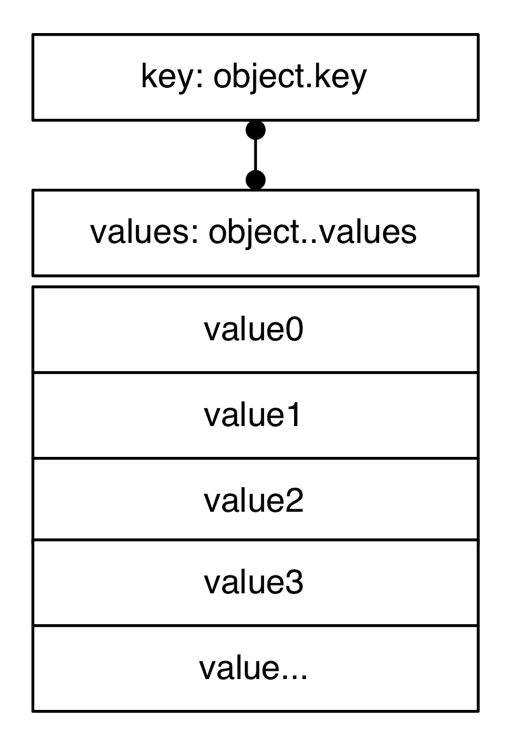

The image below shows an example of this kind of prepare/publish model. In this form, we prepare an object containing a table of flights in sorted order inside a field called Flights. The object also has a primary key field called `TailNum`, which we use to access it.

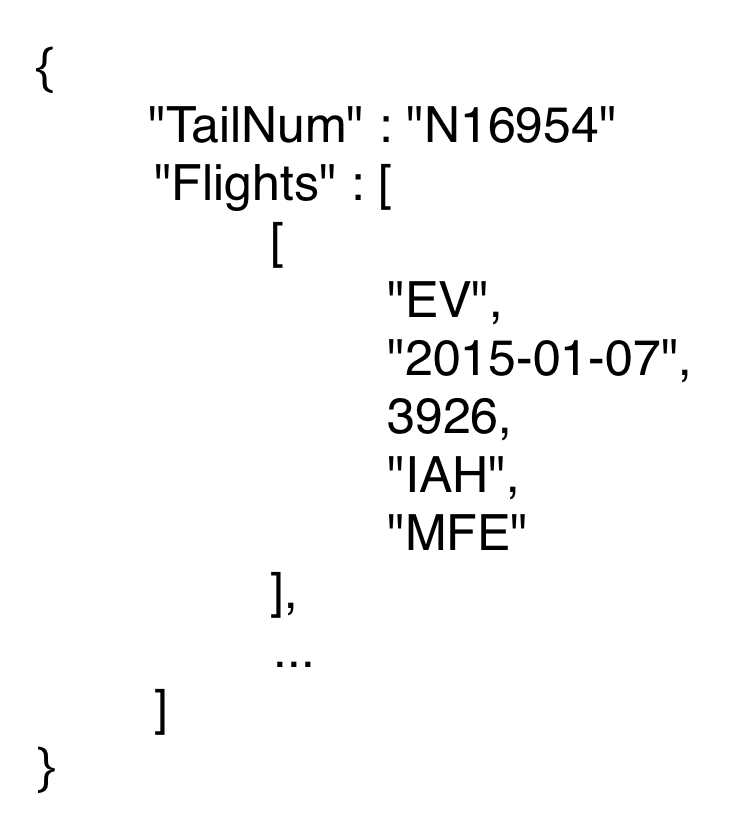

This form is the most scalable of all because you need use only a key/value store to hold the data, and to query this data you use a single, unique key. Serving data from a key/value store is a much simpler problem than most relational databases, for instance, solve. This makes them easy to operate in systems without a single point of failure. This translates into simple operations. Remember: first order form makes operations easy.

### Second Order Form

The next most scalable form takes advantage of key range scans in Google Bigtable clones like Apache HBase. Data in HBase tables is stored sorted by key, in alphabetical order. This is a critical feature because it means you can access a range of values very efficiently, the records for similar keys being near (next to) one another on disk.

Key design then becomes the mechanism through which you can perform many operations you might expect from relational databases. Apache Phoenix provides a SQL abstraction on top of HBase, which means you don’t have to employ tricks in Java to make HBase go. Phoenix is the go-to way to use HBase for application developers (who need to get things done quickly). An excellent “Introduction to HBase Schema Design” by Amandeep Khurana is available if you’d like to dive deeper.

We don’t employ HBase in the book, but the image below shows what our last example might look like in HBase land. To reproduce the query, we would compose a unique key for our data so that when stored in sorted order and retrieved by a scan against the TailNum it would produce a sorted list of flights identical to the one in the previous example.

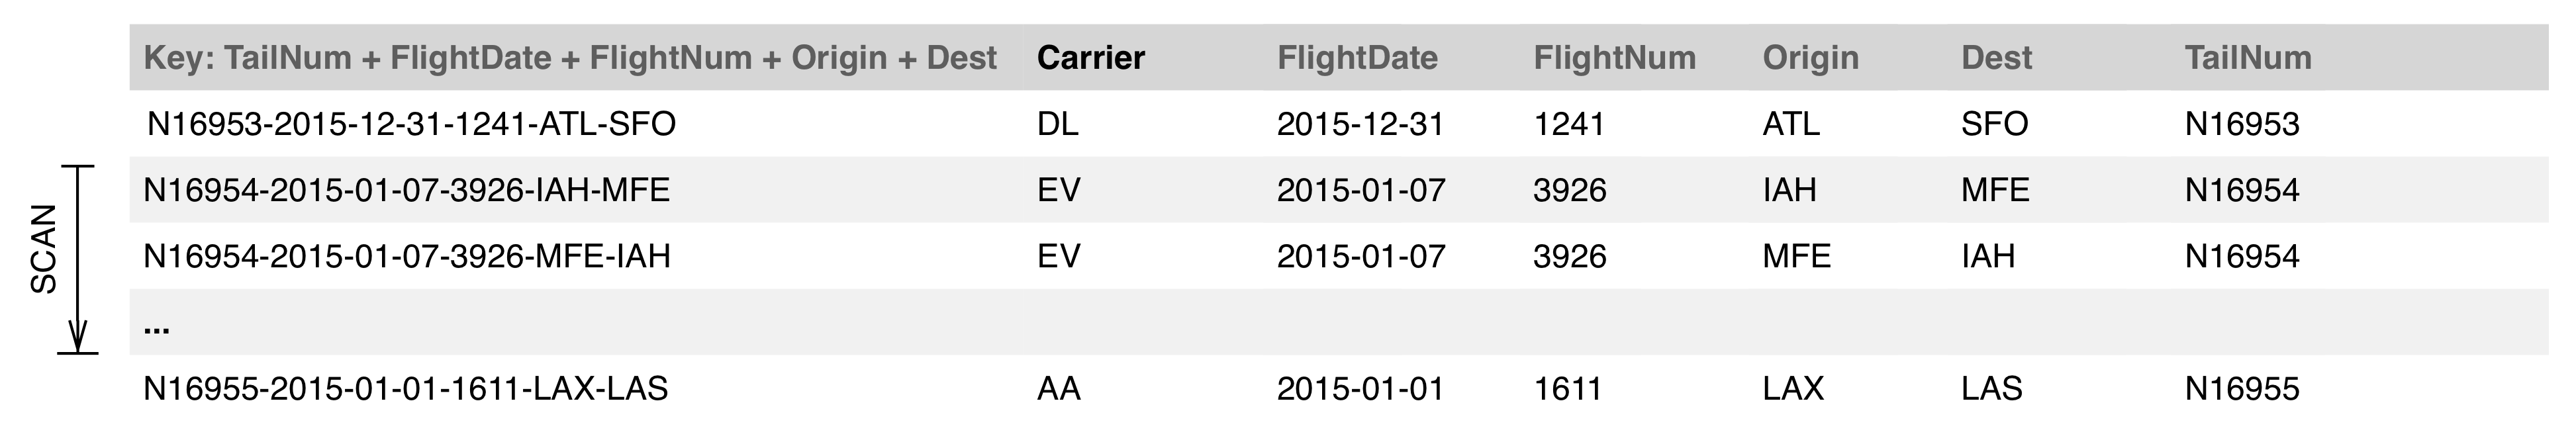

Range scans can be used to handle many types of query through novel key composition. They are surprisingly powerful, and yet they scale surprisingly well. HBase applications handling petabytes of data exist and operate with relative ease. We could easily have employed HBase and Apache Phoenix to produce many of the examples in this book. Remember: if first order form won’t work for you, second order form becomes the go-to form.

```sql
# Achieve everything many access patterns via key composition:

Requirement: SELECT FLIGHTS WHERE FlightDate < X AND FlightDate> Y

Compose Key: TailNum + FlightDate, ex. N16954-2015-12-16

Range Scan: FROM: N16954-2015-12-01 
              TO: N16954-2015-01-01
```

### Third Order Form

The next most efficient way to store data is to summarize it in terms of time or category and store the result in a database like MySQL or MongoDB that employs B-tree indexes to enable efficient lookup of portions of rows in a table, or to facilitate joins. This could replicate a range scan, or it could enable arbitrary, more complex queries that don’t resemble a range scan on a sorted table at all. These databases often include the capability to GROUP BY and compute aggregate metrics, similar to what we’ve done with Spark SQL.

Queries against relational and featureful document stores might compute any given metric at the time of query, or a hybrid approach might occur in which precomputed summaries are delivered by selecting a range of records, similar to a key range scan. We won’t demonstrate third order form in this book, but you’re probably familiar with it already. It can break the publish/decorate model we’ve used in this book, or it might simply serve range scans on preaggregated metrics.

### Choosing a Form

In general, the lower order form you choose, the easier the system is to scale, and to scale horizontally. But remember: you can always choose a more featureful database and not use its features, except in cases of dire need. For instance, you might use MySQL as a key/value store, or to serve range scans of preaggregated metrics. It will scale easily when used this way. You would have the option, however, of using a GROUP BY if you needed to, in order to more rapidly implement a new feature of your application. You could always scale the feature by moving the processing “back in the stack” to the batch layer if it proves popular.

The key lesson here is to use database features thoughtfully, because the more you use them, the more difficult your application will be to scale. Batch computation is relatively easy compared to keeping a large and featureful database instance going under heavy load. You will need to know your database well, and understand the consequences of each feature on the system overall.

## Exploring Seasonality

We have to begin somewhere, so let’s begin with a question: which is the busiest month for air travel?

This question involves seasonality. Seasonality is present when a measure changes repeatedly and consistently, depending on the time of year. For instance, Christmas light sales would display strong seasonality (although I hang them year round), with sales peaking in December every year.

This is a chance to show how SQL and NoSQL dataflows fit together and complement one another. Let’s make our first chart, in which we count the total flights by month for the year 2015. Flights by month is very easily expressible as SQL.

In [1]:
# Initialize PySpark
APP_NAME = "Introducing PySpark"

# If there is no SparkSession, create the environment
try:
  sc and spark
except NameError as e:
  import findspark
  findspark.init()
  import pyspark
  import pyspark.sql

  sc = pyspark.SparkContext()
  spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()

print("PySpark initialized...")

PySpark initialized...


In [4]:
on_time_dataframe = spark.read.parquet('../data/on_time_performance.parquet')

# Use SQL to look at the total flights by month across 2015
on_time_dataframe.registerTempTable("on_time_dataframe")
total_flights_by_month = spark.sql(
  """SELECT INT(Month), INT(Year), COUNT(*) AS total_flights
  FROM on_time_dataframe
  GROUP BY INT(Year), INT(Month)
  ORDER BY INT(Year), INT(Month)"""
)

# This map/asDict trick makes the rows print a little prettier. It is optional.
flights_chart_data = total_flights_by_month.rdd.map(lambda row: row.asDict())
flights_chart_data.collect()

[{'Month': 1, 'Year': 2015, 'total_flights': 469968},
 {'Month': 2, 'Year': 2015, 'total_flights': 429191},
 {'Month': 3, 'Year': 2015, 'total_flights': 504312},
 {'Month': 4, 'Year': 2015, 'total_flights': 485151},
 {'Month': 5, 'Year': 2015, 'total_flights': 496993},
 {'Month': 6, 'Year': 2015, 'total_flights': 503897},
 {'Month': 7, 'Year': 2015, 'total_flights': 520718},
 {'Month': 8, 'Year': 2015, 'total_flights': 510536},
 {'Month': 9, 'Year': 2015, 'total_flights': 464946},
 {'Month': 10, 'Year': 2015, 'total_flights': 486165},
 {'Month': 11, 'Year': 2015, 'total_flights': 467972},
 {'Month': 12, 'Year': 2015, 'total_flights': 479230}]